In [1]:
import random, os, gc, pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

from otto_utils import *

In [2]:
def run_lgbm(train, test, conf):
    seed_everything(conf.params['seed'])
    
    features = conf.features
    cat_features = conf.cat_features
    num_features = len(features)

    oof_predictions = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()
    
    gt_sessions_ind = np.array(train[train[f'{conf.target[:-3]}_session']==1].index)
    ###
    train['r'] = np.random.randint(0, 15, train.shape[0])
    rand_ind = np.array(
        train[
            (train[f'{conf.target[:-3]}_gt']==1)
            | (train['r']==0)
        ].index
    )
    ###
    kfold = GroupKFold(n_splits = conf.n_folds)

    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[conf.target], train['session'])):
        print('\n'+'-'*50 + f'\nTraining fold {fold} with {num_features} features...\n')
        
        trn_ind_x = np.intersect1d(trn_ind, gt_sessions_ind, assume_unique=True)
        val_ind_x = np.intersect1d(val_ind, gt_sessions_ind, assume_unique=True)
        ###
        trn_ind_x = np.intersect1d(trn_ind_x, rand_ind, assume_unique=True)
        ###
        x_train_x, x_val_x = train[features].iloc[trn_ind_x], train[features].iloc[val_ind_x]
        y_train_x, y_val_x = train[conf.target].iloc[trn_ind_x], train[conf.target].iloc[val_ind_x]
        
        x_val = train[features].iloc[val_ind]
        y_val = train[conf.target].iloc[val_ind]
        
        lgb_train = lgb.Dataset(x_train_x, y_train_x, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val_x, y_val_x, categorical_feature = cat_features)
        
        model = lgb.train(
            params = conf.params,
            train_set = lgb_train,
            num_boost_round = conf.trees,
            valid_sets = [lgb_train, lgb_valid],
            categorical_feature = cat_features,
            callbacks=[
                log_evaluation(conf.verbose),
            ] if conf.params["boosting"]=="dart" else [
                log_evaluation(conf.verbose),
                early_stopping(conf.early,verbose=True)                
            ]
        )
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = model.feature_name()
        fold_importance_df["importance"] = model.feature_importance(importance_type='split')
        fold_importance_df["importance2"] = model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        val_pred = model.predict(x_val)
        oof_predictions[val_ind] = val_pred
        
        s = pd.DataFrame({'session': train['session'], 'aid': train['aid'], 'pred': -1})
        s.loc[val_ind,'pred']=val_pred
        s = s[s['pred']>-0.5].copy()
        s = s.sort_values(['session','pred'],ascending=[True,False])
        s = s.reset_index(drop=True)
        s['n'] = s.groupby('session').cumcount()
        s = s[s['n']<20][['session','aid']].copy()
        
        test_labels = pd.read_parquet('input/otto-validation/test_labels.parquet')
        test_labels = test_labels[test_labels['type']==conf.target[:-3]].copy()
        test_labels = test_labels[test_labels['session'].isin(set(s['session']))].copy()
        test_labels['num_gt'] = test_labels['ground_truth'].apply(len)
        test_labels['num_gt'] = np.where(test_labels['num_gt']>20,20,test_labels['num_gt'])
        denom = test_labels['num_gt'].sum()
        del test_labels['type'], test_labels['num_gt']
        test_labels = test_labels.explode('ground_truth')
        test_labels.columns = ['session','aid']
        nom = len(s.merge(test_labels, on=['session','aid'],how='inner'))

        if conf.predict_test:
            test_predictions += model.predict(test[features]) / conf.n_folds
        
        score = roc_auc_score(y_val, val_pred)
        print(f'\nFold {fold} CV score is {score:.4f}')
        print(f'\nFold {fold} recall is {nom/denom:.6f}')
        print(f"nom={nom}; denom={denom}")
        
        save_object(model, f"models_new/lgb_{conf.target[:-3]}_{conf.trees}_tr_{conf.params['num_leaves']}_lv_{conf.params['boosting']}_fold_{fold}_{score:.4f}_{nom/denom:.6f}.pkl")
        
        del x_train_x, x_val_x, y_train_x, y_val_x, x_val, y_val, lgb_train, lgb_valid, s, test_labels
        gc_clear()
        
    oof = pd.DataFrame({'session': train['session'], 'aid': train['aid'], 'pred': oof_predictions})
    
    score = roc_auc_score(train[conf.target], oof_predictions)
    print(f'\nOut of folds CV score is {score:.4f}')
    
    s = oof.copy()
    s = s.sort_values(['session','pred'],ascending=[True,False])
    s = s.reset_index(drop=True)
    s['n'] = s.groupby('session').cumcount()
    s = s[s['n']<20][['session','aid']].copy()

    test_labels = pd.read_parquet('input/otto-validation/test_labels.parquet')
    test_labels = test_labels[test_labels['type']==conf.target[:-3]].copy()
    test_labels['num_gt'] = test_labels['ground_truth'].apply(len)
    test_labels['num_gt'] = np.where(test_labels['num_gt']>20,20,test_labels['num_gt'])
    denom = test_labels['num_gt'].sum()
    del test_labels['type'], test_labels['num_gt']
    test_labels = test_labels.explode('ground_truth')
    test_labels.columns = ['session','aid']
    nom = len(s.merge(test_labels, on=['session','aid'],how='inner'))
    print(f'\nOut of folds recall is {nom/denom:.6f}')
    print(f"nom={nom}; denom={denom}")
    
    save_object(oof_predictions, f"models_new/lgb_oof_{conf.target[:-3]}.pkl")
    
    if conf.predict_test:
        sub = pd.DataFrame({'session': test['session'], 'aid': test['aid'], 'pred': test_predictions})
    else:
        sub = None
        
    del s, test_labels, oof_predictions
    gc_clear()
        
    display_importances(feature_importance_df)
    feature_importance_df.to_csv(
        f"models_new/fe_lgb_{conf.target[:-3]}_{nom/denom:.6f}.csv",
        index=False
    )
    return oof, sub
    

def display_importances(feature_importance_df_):
    tops = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:80].index
    tops2 = feature_importance_df_[["feature", "importance2"]].groupby("feature").mean().sort_values(by="importance2", ascending=False)[:80].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(tops)]
    best_features2 = feature_importance_df_.loc[feature_importance_df_.feature.isin(tops2)]
    
    plt.figure(figsize=(8, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features Split (avg over folds)')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 15))
    sns.barplot(x="importance2", y="feature", data=best_features2.sort_values(by="importance2", ascending=False))
    plt.title('LightGBM Features Gain (avg over folds)')
    plt.tight_layout()
    plt.show()

In [3]:
out_dict = {
    'orders': [
        'a2s_actions_rel', 'a2s_best_action_type', 'a2s_actions_num', 'a2s_last_action_index', 'ts_diff',
        'a2s_carts_rel', 'a2s_last_click_index', 'a2s_last_cart_index', 'a2s_carts_num', 'wgt_v51ha_sum',
        'OR_estimation_frCA_trn', 'aid_CL2OR_trn', 'ts_diff_clicks', 'wgt_v21m_sum', 'session_actions',
        'session_carts', 'wgt_rel_v51ha_mean', 'wgt_v21k_sum', 'v51ha_indmin', 'wgt_rel_v51ha_sum',
        'wgt_rel_v21m_sum', 'wgt_v31m_sum', 'session_carts_avg_real', 'ts_diff_carts', 'ts_diff_orders_rel',
        'a2s_clicks_rel', 'OR_estimation_frCL_trn', 'session_clicks', 'carts_rating_full', 'ts_diff_clicks_rel',
        'session_carts_avg_hour', 'ts_diff_carts_rel', 'ts_diff_rel', 'wgt_rel_v31m_sum', 'wgt_rel_v21m_mean',
        'session_full_length', 'aid_CL2CA_tst', 'aid_CA2OR_trn', 'v21m_indmin', 'a2s_orders_rel',
        'session_items_carted', 'aid_CA_rank_int_tst_vs_trn', 'session_avg_real_length', 'ts_diff_orders',
        'carts_rating_train', 'v21k_num', 'wgt_v51ha_mean', 'orders_rating_full', 'aid_multi_orders_percent_train',
        'aid_multi_clicks_percent_full'
    ],
    'carts': [
        'a2s_last_action_index', 'ts_diff', 'a2s_actions_rel', 'ts_diff_rel', 'wgt_v51ha_sum', 'wgt_v21m_sum',
        'wgt_rel_v21m_sum', 'wgt_rel_v51ha_sum', 'session_clicks', 'wgt_v31m_sum', 'a2s_clicks_rel',
        'wgt_rel_v51ha_mean', 'wgt_v21k_sum', 'v51ha_indmin', 'session_items_clicked', 'wgt_rel_v31m_sum',
        'session_items', 'v21m_indmin', 'wgt_rel_v21k_sum', 'wgt_v11m_sum', 'a2s_last_click_index', 
        'wgt_rel_v21m_mean', 'aid_CL2CA_tst', 'ts_diff_carts_rel', 'CA_estimation_frCL_trn', 'aid_CL2CA_trn',
        'ts_diff_clicks_rel', 'clicks_rating_train', 'ts_diff_orders_rel', 'aid_CL_vs_mean_trn', 'ts_diff_clicks',
        'aid_CL_rank_int_tst_vs_trn', 'session_full_length', 'aid_multi_clicks_percent_full', 'wgt_v51ha_mean',
        'session_avg_real_items_num', 'a2s_actions_num', 'aid_CL_rank_int_trn', 'v31m_num', 'v31m_indmin',
        'a2s_clicks_num', 'CA_estimation_frCL_tst', 'wgt_rel_v21k_mean', 'aid_CL_vs_mean_tst_vs_trn',
        'aid_CL_rank_pct_tst_vs_trn', 'aid_CA_rank_int_tst_vs_trn', 'aid_CA_vs_mean_tst', 'clicks_rating_full',
        'session_click_diff_mean', 'aid_CA_vs_mean_tst_vs_trn'
    ],
    'clicks': [
        'a2s_last_action_index', 'a2s_actions_rel', 'ts_diff', 'session_actions', 'wgt_rel_v31m_mean', 
        'wgt_v31m_sum', 'wgt_rel_v11m_mean', 'v31m_indmin', 'wgt_rel_v31m_sum', 'wgt_v11m_sum', 'v11m_indmin',
        'session_items', 'session_clicks', 'session_full_length', 'wgt_v11m_mean', 'aid_CL_rank_int_tst_vs_trn',
        'wgt_v31m_mean', 'ts_diff_carts_rel', 'ts_diff_rel', 'aid_CL_vs_mean_tst_vs_trn', 'a2s_actions_num',
        'session_avg_real_items_num', 'v31m_num', 'ts_diff_orders_rel', 'ts_diff_clicks_rel', 
        'session_items_clicked', 'aid_multi_clicks_percent_full', 'aid_CL_rank_pct_tst_vs_trn', 'wgt_v51ha_sum',
        'aid_CL_vs_mean_trn', 'v21k_num', 'wgt_rel_v21k_sum', 'wgt_v21m_sum', 'carts_rating_train', 'wgt_v21m_mean', 
        'wgt_rel_v11m_sum', 'aid_CA_vs_mean_trn', 'ts_diff_clicks', 'wgt_v21k_sum', 'v11m_num', 
        'a2s_last_click_index', 'clicks_rating_full', 'wgt_rel_v21k_mean', 'clicks_rating_train', 
        'aid_clicks_favourite_dow_diff_test', 'a2s_carts_rel', 'wgt_rel_v21m_mean', 'wgt_v51ha_mean', 
        'wgt_rel_v51ha_mean', 'CA_estimation_frCL_trn'
    ]
}

In [4]:
bigram_feats = [
    'bigram_normed_clicks_sum', 'bigram_normed_clicks_mean', 'bigram_normed_clicks_max', 'bigram_normed_clicks_min', 
    'bigram_normed_clicks_last', 'bigram_normed_carts_sum', 'bigram_normed_carts_mean', 'bigram_normed_carts_max', 
    'bigram_normed_carts_min', 'bigram_normed_carts_last', 'bigram_more_clicks_sum', 'bigram_more_clicks_mean', 
    'bigram_more_clicks_max', 'bigram_more_clicks_min', 'bigram_more_clicks_last', 'bigram_more_carts_sum', 
    'bigram_more_carts_mean', 'bigram_more_carts_max', 'bigram_more_carts_min', 'bigram_more_carts_last' 
]

In [5]:
pub_sh1_1 = ['emb_diff_sh1_1_pub','emb_angle_sh1_1_pub']
pub_sh2_1 = ['emb_diff_sh2_1_pub','emb_angle_sh2_1_pub']
w2v = ['emb_diff_w2v_100','emb_angle_w2v_100']
bpr = ['bpr']

embs_feats = pub_sh1_1 + pub_sh2_1 + w2v + bpr + bigram_feats

In [6]:
needcols = ['session','aid','clicks_gt','clicks_session'] + out_dict['clicks'] + [
    'matrices_num','matrices_numsum','matrices_wgt_rel_mean'
] + pub_sh1_1 + pub_sh2_1 + w2v
train = pd.concat(
    [
        pd.read_parquet("feats/feats_0_batch_0.pqt",columns = needcols),
        pd.read_parquet("feats/feats_0_batch_1.pqt",columns = needcols),
        pd.read_parquet("feats/feats_0_batch_2.pqt",columns = needcols),
        pd.read_parquet("feats/feats_0_batch_3.pqt",columns = needcols),
    ],
    ignore_index=True
)
train

,session,aid,clicks_gt,clicks_session,a2s_last_action_index,a2s_actions_rel,ts_diff,session_actions,wgt_rel_v31m_mean,wgt_v31m_sum,wgt_rel_v11m_mean,v31m_indmin,wgt_rel_v31m_sum,wgt_v11m_sum,v11m_indmin,session_items,session_clicks,session_full_length,wgt_v11m_mean,aid_CL_rank_int_tst_vs_trn,wgt_v31m_mean,ts_diff_carts_rel,ts_diff_rel,aid_CL_vs_mean_tst_vs_trn,a2s_actions_num,session_avg_real_items_num,v31m_num,ts_diff_orders_rel,ts_diff_clicks_rel,session_items_clicked,aid_multi_clicks_percent_full,aid_CL_rank_pct_tst_vs_trn,wgt_v51ha_sum,aid_CL_vs_mean_trn,v21k_num,wgt_rel_v21k_sum,wgt_v21m_sum,carts_rating_train,wgt_v21m_mean,wgt_rel_v11m_sum,aid_CA_vs_mean_trn,ts_diff_clicks,wgt_v21k_sum,v11m_num,a2s_last_click_index,clicks_rating_full,wgt_rel_v21k_mean,clicks_rating_train,aid_clicks_favourite_dow_diff_test,a2s_carts_rel,wgt_rel_v21m_mean,wgt_v51ha_mean,wgt_rel_v51ha_mean,CA_estimation_frCL_trn,matrices_num,matrices_numsum,matrices_wgt_rel_mean,emb_diff_sh1_1_pub,emb_angle_sh1_1_pub,emb_diff_sh2_1_pub,emb_angle_sh2_1_pub,emb_diff_w2v_100,emb_angle_w2v_100
0,12629600,1673830,0,1,0,1.0,0,1,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.0,-1,1,1,0,-1.0,0.199983,-1.000000,1.661646e+09,0.000000e+00,2.392106,1,1.0,0,1.661646e+09,0.000000e+00,1,0.336283,0.417293,-1.0,1.613197,0,-1.000000,-1.0,112944,-1.0,-1.000000,2.370294,0,-1.0,0,0,133953,-1.000000,149988,0,-1.0,-1.000000,-1.0,-1.000000,0.157303,0,0,-5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,12630000,1659103,0,1,1,0.5,14,2,0.017549,358.857239,0.018626,1,0.017549,144.0,1,2,2,14,144.0,2.403694,358.857239,1.107765e+08,9.333333e-01,0.258422,1,2.0,1,1.107765e+08,9.333333e-01,2,0.314847,5.015638,45.0,30.487604,1,0.025031,421.0,4263,421.0,0.018626,42.834606,14,241.0,1,1,5787,0.025031,5615,3,-1.0,0.036532,45.0,0.070093,0.150416,5,5,1209.857239,2.852127,0.962233,0.506473,0.992621,4.375782,0.868151
2,12630000,1594331,1,1,0,0.5,0,2,0.018545,360.141388,0.016961,0,0.018545,144.0,0,2,2,14,144.0,0.385585,360.141388,1.107765e+08,0.000000e+00,0.985636,1,2.0,1,1.107765e+08,0.000000e+00,2,0.315000,0.804576,43.0,22.838514,1,0.021964,415.0,8808,415.0,0.016961,25.903932,0,240.0,1,0,7637,0.021964,8108,0,-1.0,0.029800,43.0,0.046237,0.121429,5,5,1202.141388,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,12630400,1431314,0,1,0,1.0,0,1,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.0,-1,1,1,0,-1.0,0.308408,-1.000000,1.661648e+09,0.000000e+00,1.273864,1,1.0,0,1.661648e+09,0.000000e+00,1,0.171233,0.643535,-1.0,6.942183,0,-1.000000,-1.0,41255,-1.0,-1.000000,6.433656,0,-1.0,0,0,45081,-1.000000,49281,0,-1.0,-1.000000,-1.0,-1.000000,0.099217,0,0,-5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
4,12630800,1636500,0,0,0,1.0,0,1,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.0,-1,1,1,0,-1.0,0.252042,-1.000000,1.661649e+09,0.000000e+00,1.663261,1,1.0,0,1.661649e+09,0.000000e+00,1,0.250000,0.525920,-1.0,3.480155,0,-1.000000,-1.0,273338,-1.0,-1.000000,0.846534,0,-1.0,0,0,84795,-1.000000,94627,2,-1.0,-1.000000,-1.0,-1.000000,0.026042,0,0,-5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174339,12899603,1032095,0,1,999,0.0,1661723905,2,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.0,-1,2,2,104,-1.0,4.680647,-1.000000,1.582594e+07,1.582594e+07,0.190653,0,2.0,0,1.582594e+07,1.582594e+07,2,0.364303,9.766814,4.0,75.058958,0,-1.000000,-1.0,731,-1.0,-1.000000,120.885015,1661723905,-1.0,0,999,1140,-1.000000,1096,1,-1.0,-1.000000,4.0,0.003738,0.000000,1,1,0.000000,15.861943,0.768682,6.270036,0.985916,11.098768,0.653294
2174340,12899603,1436525,0,1,999,0.0,1661723905,2,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.0,-1,2,2,104,-1.0,0.666989,-1.000000,1.582594e+07,1.582594e+07,0.670852,0,2.0,0,1.582594e+07,1.582594e+07

In [7]:
train = pd.concat(
    [
        train,
        pd.read_parquet("matrices/bigram_train_sirius.parquet",columns = bigram_feats)
    ],
    axis=1
)

In [8]:
train['bpr'] = pd.read_parquet("matrices/bpr_train_big.parquet")['bpr']

In [9]:
feats = []
catfeats = []
class CFG:
    def __init__(self):
        self.n_folds = 3
        self.trees = 1000
        self.early = 100
        self.verbose = 50
        self.params = {
            'objective': 'binary',
            #'metric': 'auc',
            'boosting': 'gbdt',
            'seed': 42,
            'num_leaves': 16,
            'learning_rate': 0.05,
            'feature_fraction': 0.80,
            'n_jobs': -1,
            'lambda_l2': 2,
            'min_data_in_leaf': 50,
        }
        self.target = 'clicks_gt'
        self.features = feats
        self.cat_features = catfeats
        self.predict_test = False


--------------------------------------------------
Training fold 0 with 80 features...

[LightGBM] [Info] Number of positive: 739220, number of negative: 5947950
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.936445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17502
[LightGBM] [Info] Number of data points in the train set: 6687170, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110543 -> initscore=-2.085206
[LightGBM] [Info] Start training from score -2.085206
Training until validation scores don't improve for 100 rounds
[50]	training's binary_logloss: 0.176548	valid_1's binary_logloss: 0.0805197
[100]	training's binary_logloss: 0.169328	valid_1's binary_logloss: 0.0778606
[300]	training's binary_logloss: 0.165716	valid_1's binary_logloss: 0.0767634
[350]	training's binary_logloss: 0.165349	valid_1's binary_logloss: 0.07666
[400]	training's binary_logloss: 0.16

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110607 -> initscore=-2.084554
[LightGBM] [Info] Start training from score -2.084554
Training until validation scores don't improve for 100 rounds
[50]	training's binary_logloss: 0.176405	valid_1's binary_logloss: 0.0804861
[100]	training's binary_logloss: 0.169148	valid_1's binary_logloss: 0.0778262
[150]	training's binary_logloss: 0.167521	valid_1's binary_logloss: 0.0773319
[200]	training's binary_logloss: 0.166613	valid_1's binary_logloss: 0.0770661
[250]	training's binary_logloss: 0.166002	valid_1's binary_logloss: 0.076893
[300]	training's binary_logloss: 0.165549	valid_1's binary_logloss: 0.0767707
[350]	training's binary_logloss: 0.165188	valid_1's binary_logloss: 0.0766667
[400]	training's binary_logloss: 0.164875	valid_1's binary_logloss: 0.0765793
[450]	training's binary_logloss: 0.164614	valid_1's binary_logloss: 0.0765051
[500]	training's binary_logloss: 0.164383	valid_1's binary_logloss: 0.0764393
[550]	training's binary_lo

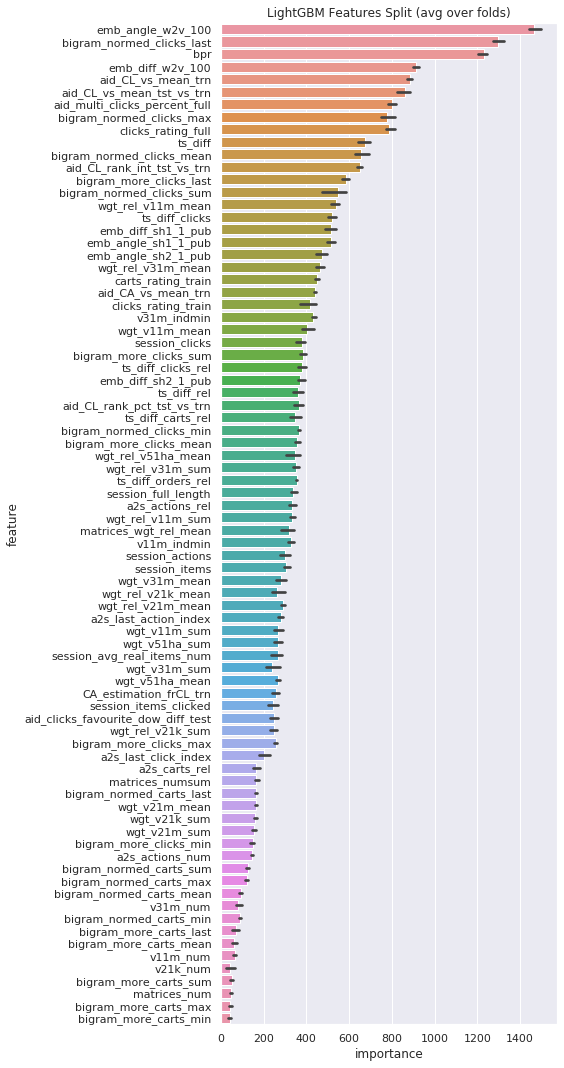

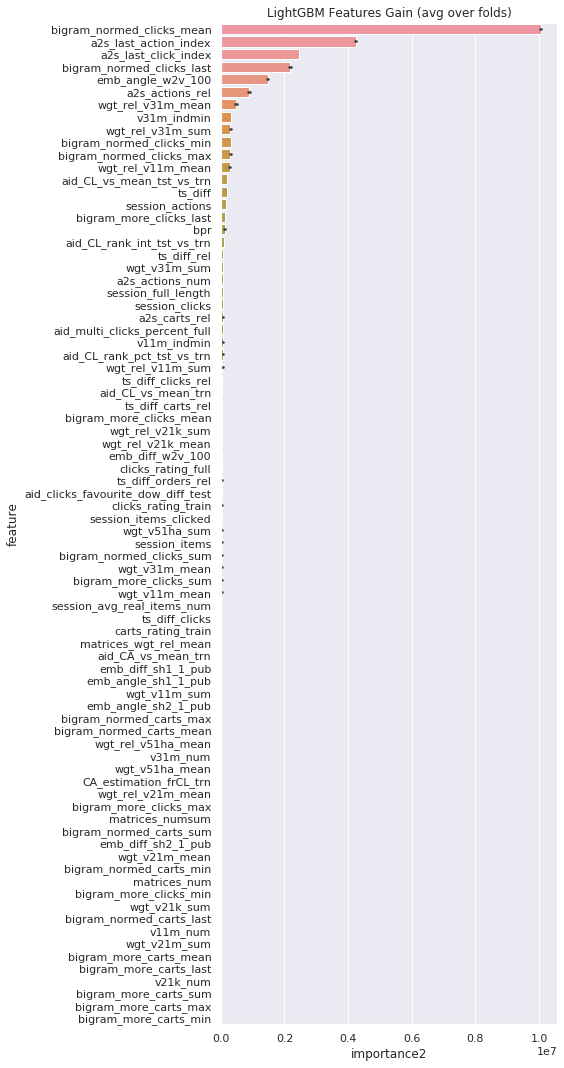

In [10]:
C1 = CFG()
C1.trees = 2000
C1.params['seed'] = 42
C1.params['learning_rate'] = 0.05
C1.params['min_data_in_leaf'] = 20
C1.features = out_dict['clicks'] + [
    'matrices_num','matrices_numsum','matrices_wgt_rel_mean'
] + embs_feats
C1.cat_features = ['a2s_best_action_type'] if ('a2s_best_action_type' in C1.features) else []
C1.target = 'clicks_gt'

clicks_oof, _ = run_lgbm(train, None, C1)